# Unsupervised Experiment

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Get results data

Please select a measure for the analysis. You can choose between VUS_PR and AUC_PR. 

In [19]:
measure_name = 'VUS_PR'
test_size = 1

all_method_score = ['convnet_default_128_score',
             'resnet_default_1024_score',
             'rocket_128_score',
             'knn_1024_score',
             'sit_stem_original_512_score',
             'Avg Ens']

all_method_score_name = ['convnet',
             'resnet',
             'rocket',
             'knn',
             'sit_stem',
             'Avg Ens']

In [20]:
def read_df(measure_name,test_size,split_number):
    df = pd.read_csv('../../results/unsupervised_results/{}/testsize_{}_split_{}.csv'.format(measure_name,test_size,split_number))
    df = df.rename(columns={'Unnamed: 0':'filename'})
    df = df.set_index('filename')
    return df

## Trained on 15 datasets, tested on 1

Here we train the methods on 15 datasets and test on one dataset (not seem in the train)

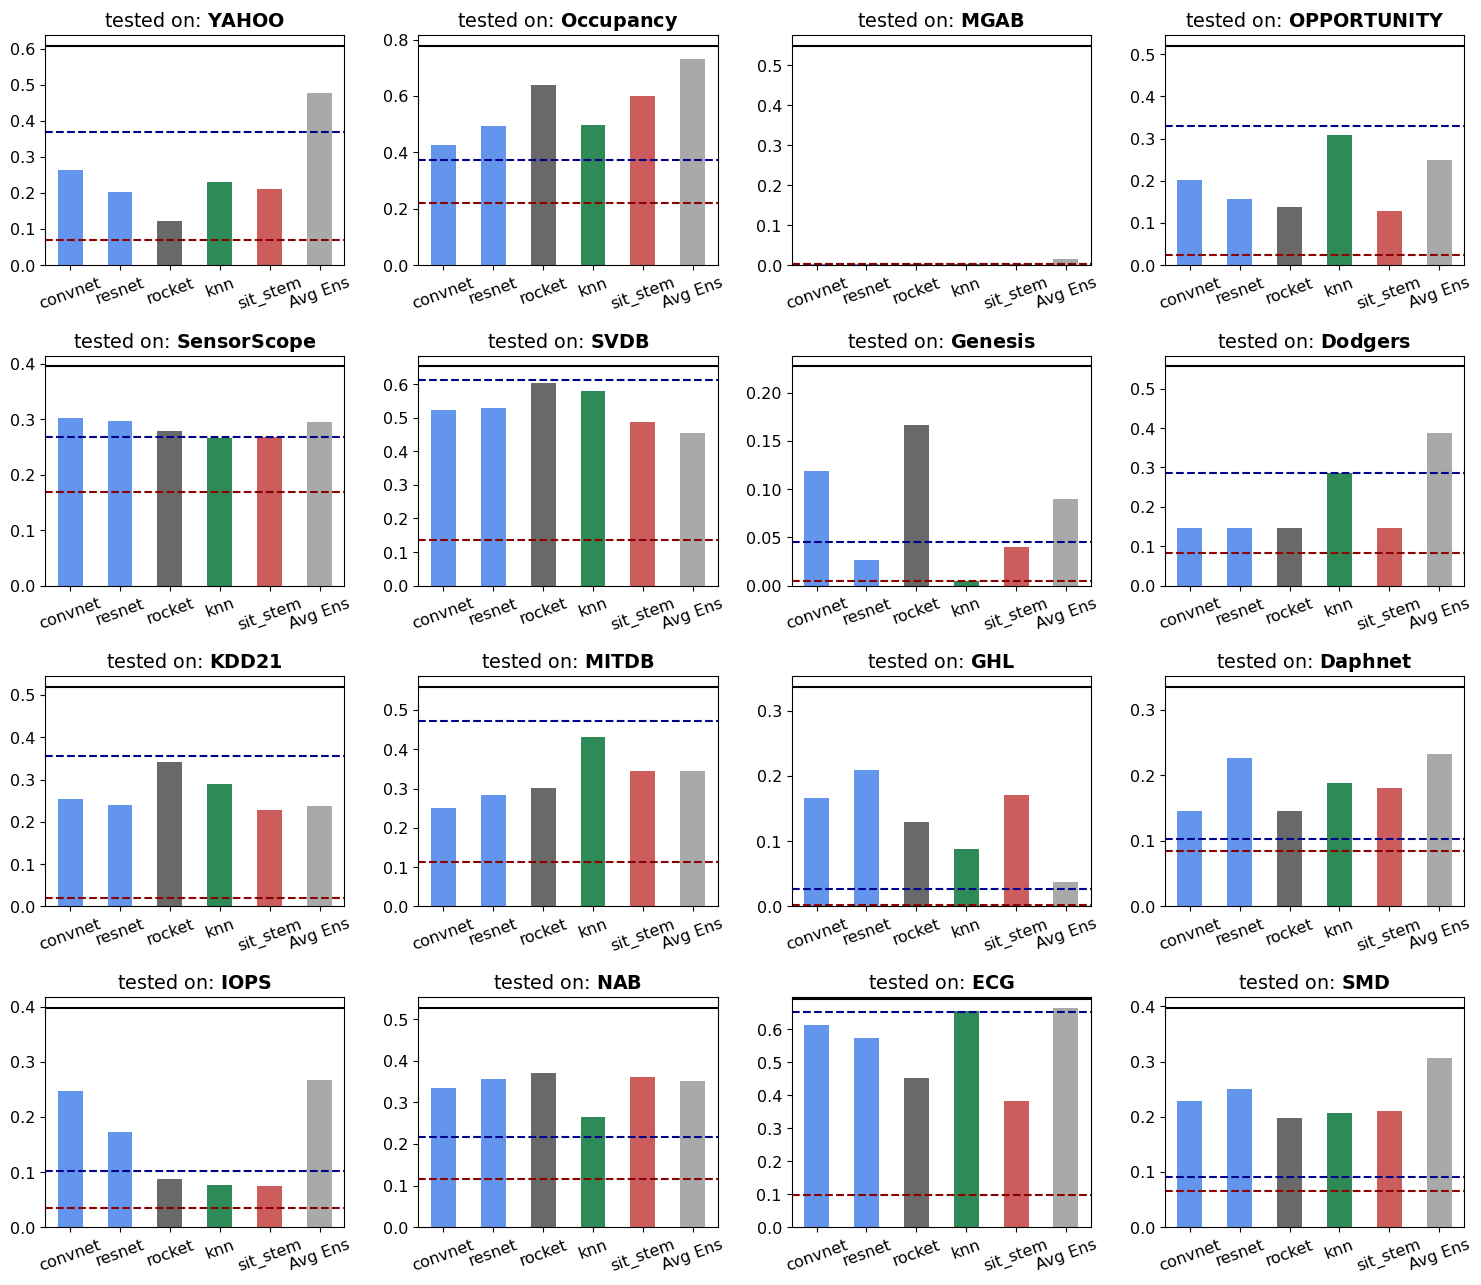

In [21]:
plt.rcParams.update({'font.size': 11.5})

all_dataset = []
all_methods = None
for split_number in range(16):
    df = read_df(measure_name,test_size,split_number)
    all_dataset.append(df.index[0].split('/')[0])
    all_methods = list(df[all_method_score+['Oracle','best_ad_train','worst_ad_test']].mean().index)

    
df_transfer_res = pd.DataFrame(index=all_dataset,columns=all_methods)
for split_number in range(16):
    df = read_df(measure_name,test_size,split_number)
    for method in all_methods:
        df_transfer_res.at[df.index[0].split('/')[0],method] = df[method].mean()
        


n_col = 4
n_row = 4
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(15,13))
for i,dataset in enumerate(all_dataset):
    my_colors = list(islice(cycle(['cornflowerblue', 'cornflowerblue', 'dimgrey', 'seagreen', 'indianred','darkgrey']), None, len(df_transfer_res[all_method_score].loc[dataset])))
    df_transfer_res[all_method_score].loc[dataset].plot(kind='bar',ax=axes[i//n_col,i%n_col],color=my_colors)
    axes[i//n_col,i%n_col].axhline(df_transfer_res['Oracle'].loc[dataset],linestyle='-',color='black')
    axes[i//n_col,i%n_col].axhline(df_transfer_res['best_ad_train'].loc[dataset],linestyle='--',color='darkblue')
    axes[i//n_col,i%n_col].axhline(df_transfer_res['worst_ad_test'].loc[dataset],linestyle='--',color='darkred')
    axes[i//n_col,i%n_col].set_title(r"tested on: $\bf{" + dataset + "}$")
    axes[i//n_col,i%n_col].set_xticks(range(len(all_method_score)),all_method_score_name,rotation=20)
plt.tight_layout()

## Overall results

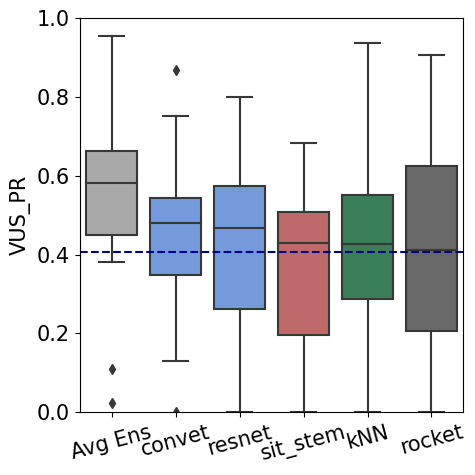

In [26]:
df_to_plot = df_transfer_res[all_method_score].subtract(df_transfer_res['worst_ad_test'], axis=0).div(df_transfer_res['Oracle']-df_transfer_res['worst_ad_test'],axis=0)

order = list(df_to_plot.median().sort_values().index)[::-1]

plt.rcParams.update({'font.size': 15})

my_pal = {"Avg Ens": "darkgrey", "convnet_default_128_score": "cornflowerblue", "resnet_default_1024_score":"cornflowerblue", 'knn_1024_score':'seagreen', 'rocket_128_score':'dimgrey', 'sit_stem_original_512_score':'indianred'}
names_graph = ['Avg Ens','convet','resnet','sit_stem','kNN','rocket']

plt.figure(figsize=(5,5))
sns.boxplot(df_to_plot,order=order,palette=my_pal)
plt.xticks(list(range(len(names_graph))),names_graph,rotation=15)
plt.ylim(0,1)
plt.ylabel(measure_name)
plt.axhline(df_transfer_res['best_ad_train'].subtract(df_transfer_res['worst_ad_test'], axis=0).div(df_transfer_res['Oracle']-df_transfer_res['worst_ad_test'],axis=0).mean(),linestyle='--',color='darkblue')
plt.tight_layout()